<div style="text-align:center">
    <h1>
        Advantage Actor-Critic (A2C)
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods. The resulting algorithm is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy:
</div>

\begin{equation}
\hat G_t = R_{t+1} + \gamma v(S_{t+1}|w)
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')

In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: (array([ 0.99684095,  0.07942399,  0.99688745,  0.07883815,  0.08714467,
       -0.0661534 ], dtype=float32), {})


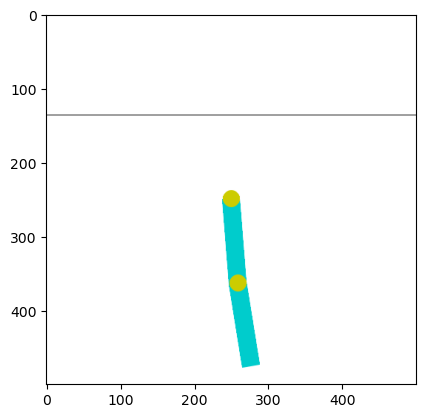

In [4]:
plt.imshow(env.render())

### Parallelize the environment

In [5]:
# num_envs = os.cpu_count()
num_envs = 8

In [6]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)

    return env

In [7]:
env_fns = [lambda: create_env('Acrobot-v1', rank) for rank in range(num_envs)]

parallel_env = ParallelEnv(env_fns)

### Prepare the environment to work with PyTorch

In [8]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [10]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1))

### Create the value network $v(s)$

In [11]:
value_net = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1), # we only want the value of the given state as output, hence output_dim=1
)

## Implement the algorithm

</br>

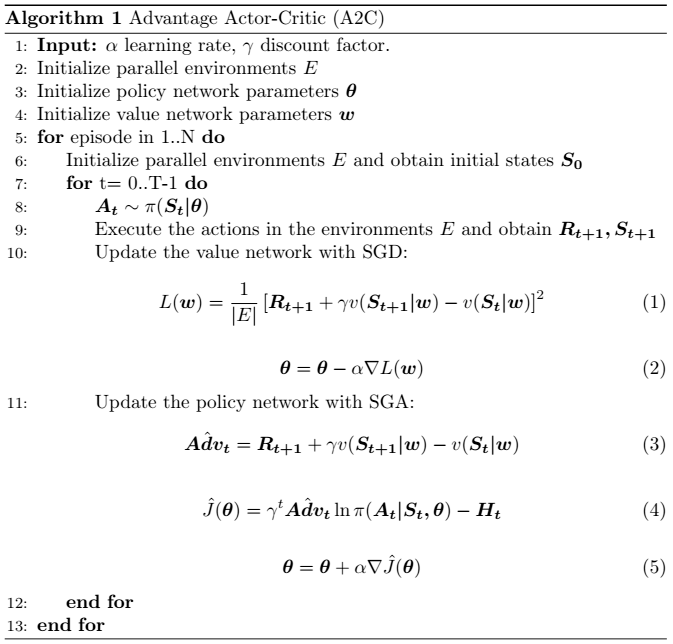

In [12]:
def a2c(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    
    policy_optimizer = AdamW(policy.parameters(), lr=alpha)
    value_optimizer = AdamW(value_net.parameters(), lr=alpha)
    # policy is the actor and value_net is the critic
    stats = {'Actor loss': [], 'Critic loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        gamma_t = 1. # gamma^t
        
        while not done_b.all():
            # We call the policy with the present state to generate the vectors of probabilities.
            # And from each vector, we'll use the multinomial function
            # to pick a single action based on those probabilities.
            # with detach() tensor doesn't take part in the back prop
            # that PyTorch uses to update the neural networks.
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)            
            
            # critic
            value = value_net(state)
            # we use detach because in cost function, we want to compute the gradient with
            # respect to the present estimates (value)
            # the target doesn't take part in the update
            target_value = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss =F.mse_loss(target_value, value)
            
            value_net.zero_grad()
            critic_loss.backward()
            value_optimizer.step()
            
            #actor
            advantage = (target_value - value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_probs = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - gamma_t * action_log_probs * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            
            policy.zero_grad()
            actor_loss.backward()
            policy_optimizer.step()
            
            state = next_state
            done_b |= done
            ep_return += reward
            gamma_t *= gamma
            
        stats['Actor loss'].append(actor_loss.item())
        stats['Critic loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [13]:
stats = a2c(policy, value_net, 200)

100%|█████████████████████████████████████████| 200/200 [01:21<00:00,  2.45it/s]


## Show results

### Show execution stats

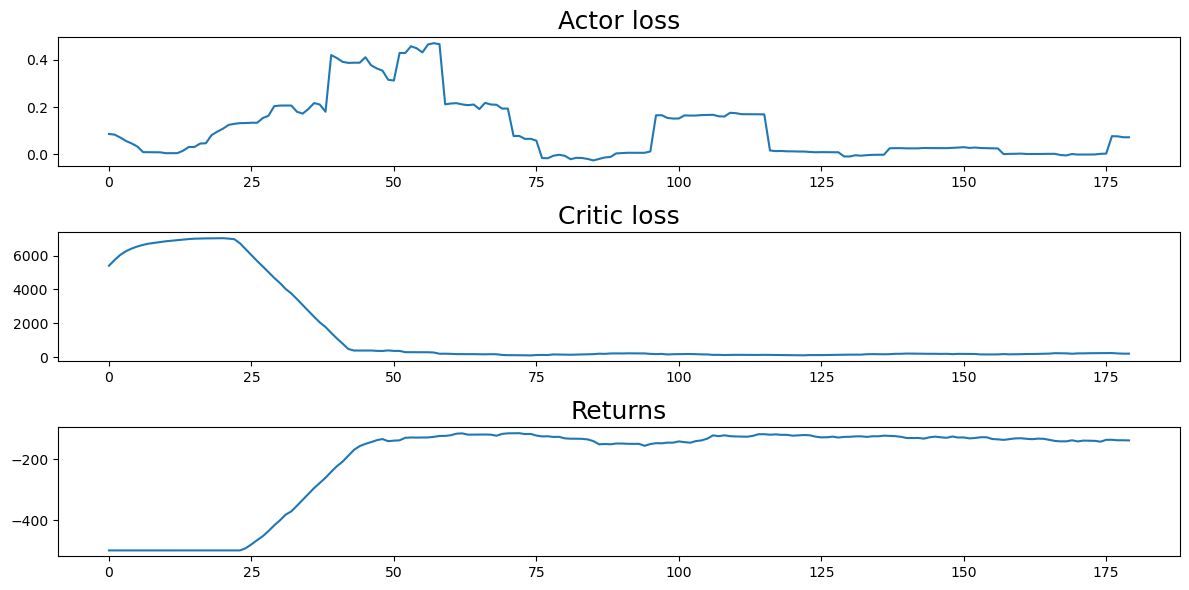

In [14]:
plot_stats(stats)

### Test the resulting agent

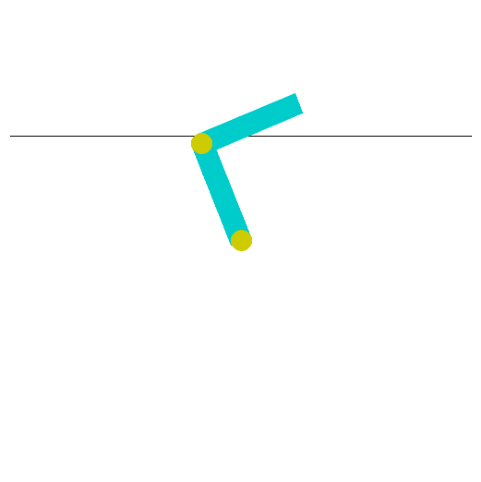

In [18]:
test_policy_network(env, policy, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)